# Prediction Strength - a simple, yet relatively unknown way to evaluate clustering

## Setup

In [1]:
import numpy as np
import sys

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

In [2]:
%config InlineBackend.figure_format = 'retina'

## Generating data

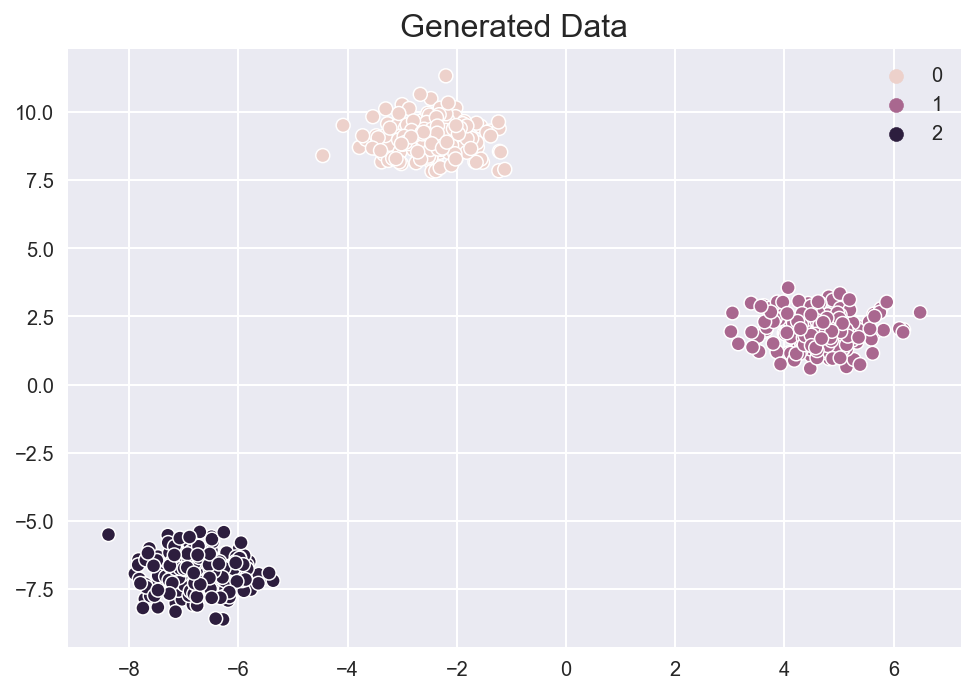

In [8]:
X, y = make_blobs(n_samples=600, centers=3, cluster_std=0.6, random_state=42)

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
ax.set_title('Generated Data', fontsize=16);

## Elbow plot approach

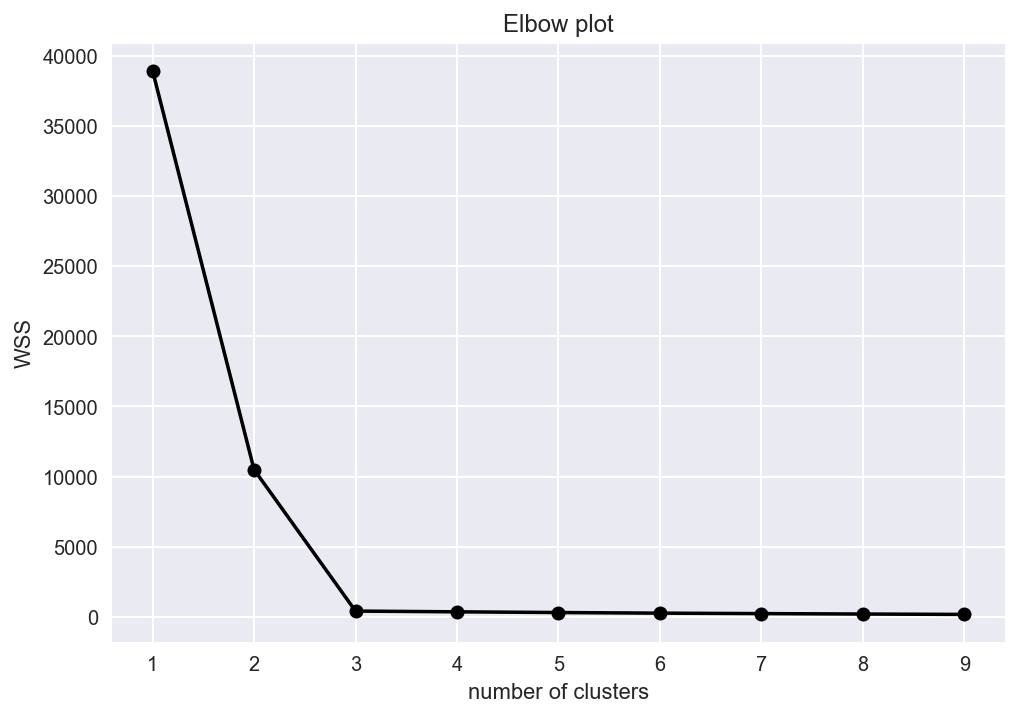

In [9]:
# setting the range of k
clusters = range(1, 10)

# running the clustering 
wss_list = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(X)
    wss_list.append(model.inertia_)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

## Prediction strength approach

In [10]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [11]:
# defining functions for calculating prediction strength

def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

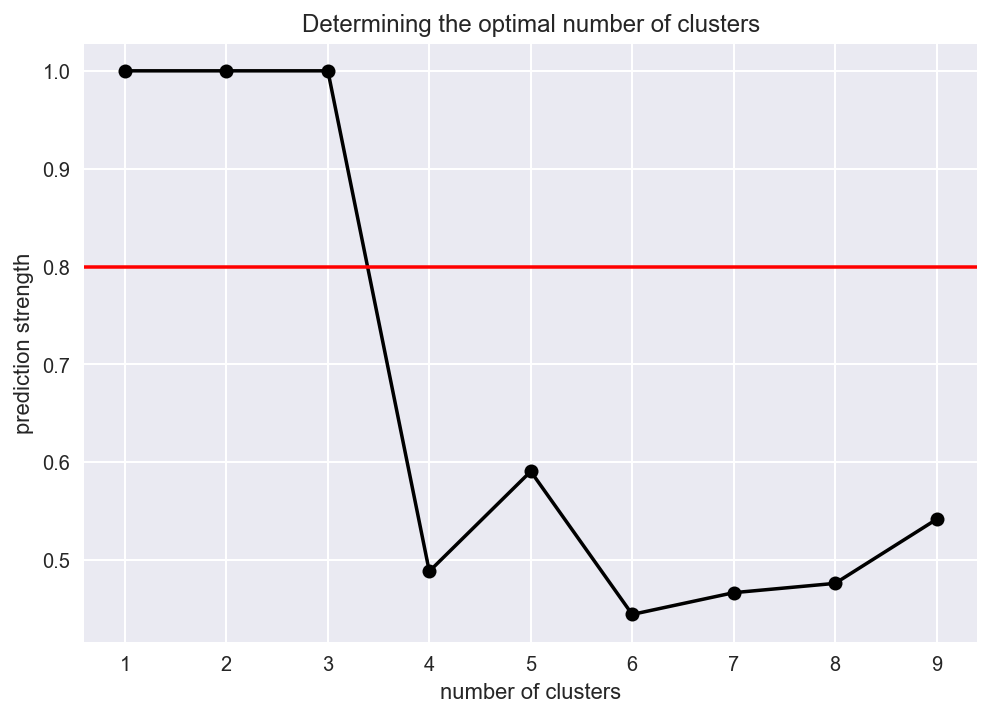

In [12]:
# running the clustering 
strengths = []
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');